In [7]:
import sys
sys.path.append('../')

import torch
from torchvision import transforms, models
from torchvision.io import read_image
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from models import get_encoder_architecture_usage
import argparse
from optimize_filter.tiny_network import U_Net_tiny
from util import clamp_batch_images

torch.cuda.set_device(1)

args=argparse.Namespace(
    pretrained_encoder='../output/cifar10/clean_encoder/model_1000.pth',
    encoder_usage_info='cifar10',
    filter='../output/cifar10/svhn_backdoored_encoder/2023-12-26-13:50:32/unet_filter_200_trained.pt',
)

test_transform_cifar10 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])
    ])

# Define the transform
finetune_transform_cifar10 = transforms.Compose([
    # transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])
])

# Load the image
img_path = '../data/cifar10/test/image_2_label_[8].jpeg'  # Replace with the path to the image file
original_image = Image.open(img_path).convert('RGB')

# Let's assume we want to generate 100 transformed versions of the image
num_samples = 2000
all_transformed_images = []

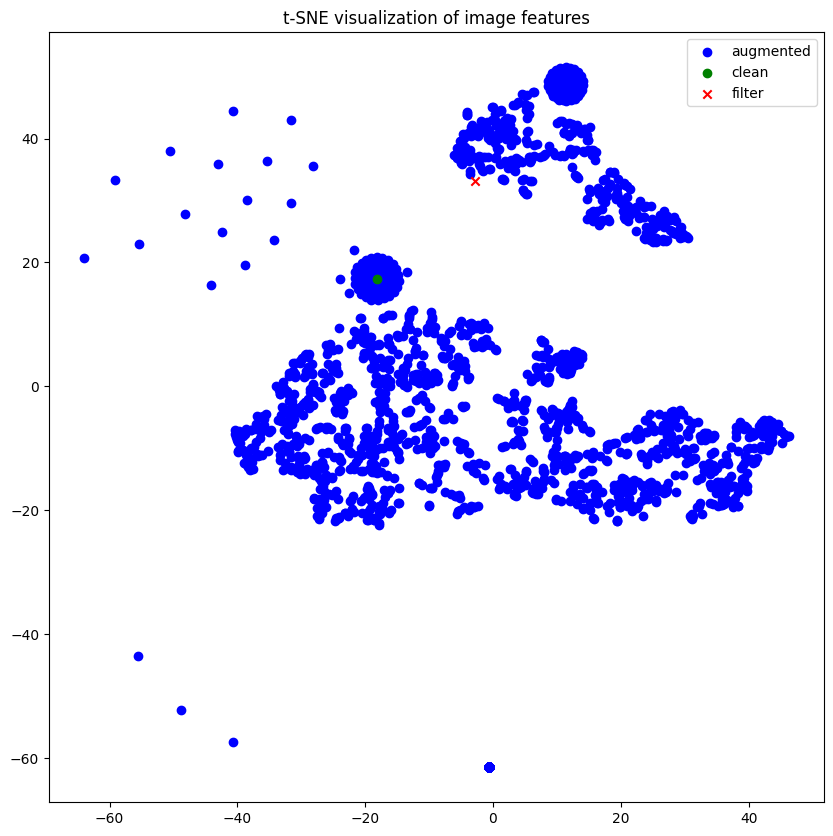

In [8]:



# Load a pretrained encoder
# Here we will use resnet18 as an example of an encoder, but this could be any model

checkpoint = torch.load(args.pretrained_encoder)
encoder = get_encoder_architecture_usage(args).cuda()
encoder.load_state_dict(checkpoint['state_dict'])

net = U_Net_tiny(img_ch=3,output_ch=3)
state_dict = torch.load(args.filter, map_location=torch.device('cuda:0'))
net.load_state_dict(state_dict['model_state_dict'])
net=net.cuda().eval()

# Ensure the encoder is in evaluation mode
encoder.eval()


# Apply the transformation multiple times to the image
for _ in range(num_samples):
    transformed_image = finetune_transform_cifar10(original_image)
    all_transformed_images.append(transformed_image)

transformed_image_clean = test_transform_cifar10(original_image)
all_transformed_images.append(transformed_image_clean) # clean image

img_backdoor_filter=net(transformed_image_clean.unsqueeze(0).cuda())
img_backdoor_filter=clamp_batch_images(img_backdoor_filter,args).squeeze(0).detach().cpu() # filter image

all_transformed_images.append(img_backdoor_filter)

# Convert list of tensors to a single tensor
all_transformed_images_tensor = torch.stack(all_transformed_images).cuda()


# Disable gradient computation since we are only doing inference
with torch.no_grad():
    # Pass the transformed images through the encoder
    encoded_features = encoder(all_transformed_images_tensor)

features_np = encoded_features[0].detach().cpu().numpy()

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=0)
features_tsne = tsne.fit_transform(features_np)

transformed_aug = features_tsne[:-2]
transformed_clean = features_tsne[-2:-1]
transformed_filter = features_tsne[-1:]

# Plotting the t-SNE reduced features
plt.figure(figsize=(10, 10))
plt.scatter(transformed_aug[:, 0], transformed_aug[:, 1], c='blue', label='augmented')
plt.scatter(transformed_clean[:, 0], transformed_clean[:, 1], c='green', label='clean')
plt.scatter(transformed_filter[:, 0], transformed_filter[:, 1], c='red', label='filter', marker='x')
plt.title('t-SNE visualization of image features')
# plt.xlabel('Component 1')
# plt.ylabel('Component 2')
plt.legend()
plt.show()
